In [1]:
import numpy as np
import healpy as hp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import xarray as xr

Helper functions for interpolation

In [2]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)), balanced_tree=False, compact_nodes=False)
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

Open catalog

In [3]:
import intake
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["EU"]

In [4]:
print(list(cat))

['CERES_EBAF', 'ERA5', 'IR_IMERG', 'JRA3Q', 'MERRA2', 'casesm2_10km_nocumulus', 'icon_d3hp003', 'icon_d3hp003aug', 'icon_d3hp003feb', 'icon_ngc4008', 'ifs_tco2559_rcbmf', 'ifs_tco3999-ng5_deepoff', 'ifs_tco3999-ng5_rcbmf', 'ifs_tco3999-ng5_rcbmf_cf', 'ifs_tco3999_rcbmf', 'nicam_220m_test', 'nicam_gl11', 'scream-dkrz', 'tracking-d3hp003', 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest', 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest', 'um_glm_n1280_CoMA9_TBv1p2', 'um_glm_n1280_GAL9', 'um_glm_n2560_RAL3p3']


Open models that have wind data on hourly resolution

In [5]:
icon_d3hp003 = cat["icon_d3hp003"](time='PT1H', time_method='inst', zoom=11).to_dask()
nicam_gl11 = cat["nicam_gl11"](time='PT1H', zoom=9).to_dask()
casesm2_10km_nocumulus = cat["casesm2_10km_nocumulus"](time='PT1H', zoom=8).to_dask()
ifs_tco3999_ng5_rcbmf = cat["ifs_tco3999-ng5_rcbmf"](time='PT1H', zoom=11).to_dask()
ifs_tco3999_rcbmf = cat["ifs_tco3999_rcbmf"](time='PT1H', zoom=11).to_dask()

/work/ab0995/a270088/mambaforge/envs/hk25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/ab0995/a270088/mambaforge/envs/hk25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/ab0995/a270088/mambaforge/envs/hk25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArr

Compute wind speed for each model

In [7]:
u = icon_d3hp003['ts'][1,:]
# v = icon_d3hp003['vas'][1,:]
speed_icon_d3hp003 = u.values
# u = nicam_gl11['uas'][1,:]
# v = nicam_gl11['vas'][1,:]
# speed_nicam_gl11 = np.hypot(u, v).values
u = casesm2_10km_nocumulus['ts'][1,:]
# v = casesm2_10km_nocumulus['vas'][1,:]
speed_casesm2_10km_nocumulus = u.values
u = ifs_tco3999_ng5_rcbmf['2t'][1,:]
# v = ifs_tco3999_ng5_rcbmf['10v'][1,:]
speed_ifs_tco3999_ng5_rcbmf = u.values
u = ifs_tco3999_rcbmf['2t'][1,:]
# v = ifs_tco3999_rcbmf['10v'][1,:]
speed_ifs_tco3999_rcbmf = u.values

Open ERA5 form Google

In [8]:
era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)

Subseting

In [9]:
era5_subset = era5.sel(time=slice('2020-01-01', '2020-02-01'))

Compute wind speed for ERA5

In [10]:
u = era5_subset['2m_temperature'][1,:]
# v = era5_subset['10m_u_component_of_wind'][1,:]
speed_era5_lonlat = u.values

Getting ERA5 coordinates

In [11]:
era_lon = era5_subset.longitude.values
era_lat = era5_subset.latitude.values
# put coordinates to -180 180 format
era_lon = np.where(era_lon>180, era_lon-360, era_lon)
era_lon2, era_lat2 = np.meshgrid(era_lon, era_lat)

Getting healpix coordinates for 

In [12]:
zoom_target = 11  # desired interpolation resolution
healpix_nside = 2 ** zoom_target
npix = hp.nside2npix(healpix_nside)
healpix_lons, healpix_lats = hp.pix2ang( 
        healpix_nside, np.arange(npix), nest=True, lonlat=True
    )

Very simple interpolation from regular grid to healpix

In [13]:
distances, inds = create_indexes_and_distances( era_lon2.ravel(), era_lat2.ravel(), healpix_lons, healpix_lats, k=1, workers=10)

In [14]:
speed_era5_lonlat = speed_era5_lonlat.ravel()
# data_sample2 = data['2t'][1106,:]

radius_of_influence=1000000
speed_era5_healpix = speed_era5_lonlat[inds]
speed_era5_healpix[distances >= radius_of_influence] = np.nan
# data_interpolated = data_interpolated.reshape(lon2.shape)
speed_era5_healpix = np.ma.masked_invalid(speed_era5_healpix)

Test plot to make sure things are working

/tmp/ipykernel_2096411/1065024330.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


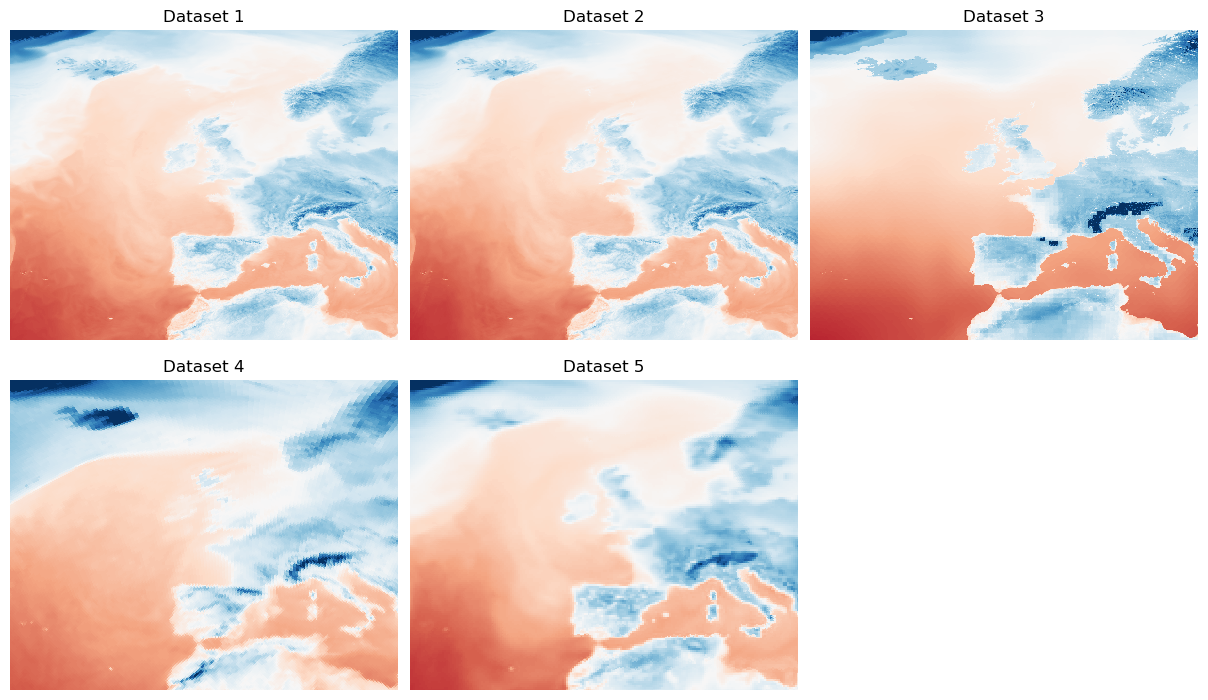

In [18]:
# suppose you have a list of maps to plot
maps = [speed_ifs_tco3999_ng5_rcbmf,
        speed_ifs_tco3999_rcbmf,
        speed_icon_d3hp003,
        speed_casesm2_10km_nocumulus,
        # speed_nicam_gl11,
        speed_era5_healpix]


nrows, ncols = 2, 3
vmin, vmax = 260, 300

fig = plt.figure(figsize=(12, 7))
# make room on the right for a single shared colorbar
fig.subplots_adjust(wspace=0.05, hspace=0.1, right=0.88)

for idx, m in enumerate(maps):
    sub = 100*nrows + 10*ncols + (idx+1)
    hp.cartview(
        m,
        sub=sub,
        nest=True,
        flip='geo',
        lonra=[-30, 20],
        latra=[30, 70],
        min=vmin, max=vmax,
        cbar=False,
        notext=True,
        title=f'Dataset {idx+1}',
        cmap =cm.RdBu_r,

    )

# **Now** the current axes (gca) is still the last map axes.
map_ax = plt.gca()
# grab its image artist
im = map_ax.get_images()[0]

# only now add the colorbar axes in the margin
# cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
# cb = fig.colorbar(im, cax=cax, orientation='vertical')
# cb.set_label('speed')
plt.tight_layout()

# plt.show()

In [ ]:
for i in range(1,1000):

    u = icon_d3hp003['ts'][i,:]
    # v = icon_d3hp003['vas'][1,:]
    speed_icon_d3hp003 = u.values
    # u = nicam_gl11['uas'][1,:]
    # v = nicam_gl11['vas'][1,:]
    # speed_nicam_gl11 = np.hypot(u, v).values
    u = casesm2_10km_nocumulus['ts'][i,:]
    # v = casesm2_10km_nocumulus['vas'][1,:]
    speed_casesm2_10km_nocumulus = u.values
    u = ifs_tco3999_ng5_rcbmf['2t'][i,:]
    # v = ifs_tco3999_ng5_rcbmf['10v'][1,:]
    speed_ifs_tco3999_ng5_rcbmf = u.values
    u = ifs_tco3999_rcbmf['2t'][i,:]
    # v = ifs_tco3999_rcbmf['10v'][1,:]
    speed_ifs_tco3999_rcbmf = u.values

    u = era5_subset['2m_temperature'][i,:]
    # v = era5_subset['10m_u_component_of_wind'][1,:]
    speed_era5_lonlat = u.values

    speed_era5_lonlat = speed_era5_lonlat.ravel()

    radius_of_influence=1000000
    speed_era5_healpix = speed_era5_lonlat[inds]
    speed_era5_healpix[distances >= radius_of_influence] = np.nan
    # data_interpolated = data_interpolated.reshape(lon2.shape)
    speed_era5_healpix = np.ma.masked_invalid(speed_era5_healpix)
    
    
    maps = [speed_ifs_tco3999_ng5_rcbmf,
        speed_ifs_tco3999_rcbmf,
        speed_icon_d3hp003,
        speed_casesm2_10km_nocumulus,
        # speed_nicam_gl11,
        speed_era5_healpix]

    titles = ["ifs_tco3999_ng5_rcbmf",
        "ifs_tco3999_rcbmf",
        "icon_d3hp003",
        "casesm2_10km_nocumulus",
        # "speed_nicam_gl11",
        "era5_healpix"]

    nrows, ncols = 2, 3
    vmin, vmax = 260, 300
    
    fig = plt.figure(figsize=(12, 7))
    # make room on the right for a single shared colorbar
    fig.subplots_adjust(wspace=0.05, hspace=0.1, right=0.88)
    
    for idx, model_data in enumerate(zip(maps, titles)):
        m = model_data[0]
        title = model_data[1]
        sub = 100*nrows + 10*ncols + (idx+1)
        hp.cartview(
            m,
            sub=sub,
            nest=True,
            flip='geo',
            lonra=[-30, 20],
            latra=[30, 70],
            min=vmin, max=vmax,
            cbar=False,
            notext=True,
            title=title,#f'Dataset {idx+1}',
            cmap = cm.RdBu_r,
    
        )
    
    # **Now** the current axes (gca) is still the last map axes.
    map_ax = plt.gca()
    # grab its image artist
    im = map_ax.get_images()[0]

    plt.tight_layout()
    plt.savefig(f'/work/ab0995/a270088/HK25/wind_coupled_amip_eu_temp/{str(i).zfill(10)}_wind.png')
    plt.close(fig)
    print(f"Saved frame {i}")

/tmp/ipykernel_2096411/668274160.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved frame 1
Saved frame 2
Saved frame 3
Saved frame 4
Saved frame 5
Saved frame 6
Saved frame 7
Saved frame 8
Saved frame 9
Saved frame 10
Saved frame 11
Saved frame 12
Saved frame 13
Saved frame 14
Saved frame 15
Saved frame 16
Saved frame 17
Saved frame 18
Saved frame 19
Saved frame 20
Saved frame 21
Saved frame 22
Saved frame 23
Saved frame 24
Saved frame 25
Saved frame 26
Saved frame 27
Saved frame 28
Saved frame 29
Saved frame 30
Saved frame 31
Saved frame 32
Saved frame 33
Saved frame 34
Saved frame 35
Saved frame 36
Saved frame 37
Saved frame 38
Saved frame 39
Saved frame 40
Saved frame 41
Saved frame 42
Saved frame 43
Saved frame 44
Saved frame 45
Saved frame 46
Saved frame 47
Saved frame 48
Saved frame 49
Saved frame 50
Saved frame 51
Saved frame 52
Saved frame 53
Saved frame 54
Saved frame 55
Saved frame 56
Saved frame 57
Saved frame 58
Saved frame 59
Saved frame 60
Saved frame 61
Saved frame 62
Saved frame 63
Saved frame 64
Saved frame 65
Saved frame 66
Saved frame 67
Save